In [2]:
from google.colab import drive
#drive.mount('/content/drive')

Goal:
Test whether this approach can achieve better paper clustering than K-Means

Approach:

Paper preprocessing

Define Autoencoder model

Define ClusteringLayer

Define DEC and visualice cluster

Step 1: Estimating the number of clusters

Step 2: Creating and training a K-means model

Step 3: Creating and training an autoencoder

Step 4: Implementing DEC Soft Labeling

Step 5: Creating a new DEC model

Step 6: Training the New DEC Model

Step 7: Using the Trained DEC Model for Predicting Clustering Classes

Step 8: Jointly Refining DEC Model

Step 9: Using Refined DEC Model for Predicting Clustering Classes

Step 10: Comparing with K-means

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [4]:
df = pd.read_csv('/content/drive/My Drive/edited_topics_all_news.csv')

Text tokenize

Now we tokenize and vectorize the "body_text" column with the Keras built in tokenizer. We tokenize the body text of all papers

In [5]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MinMaxScaler


maxlen = 4096 #only use this number of most frequent words
training_samples = 8000
validation_samples = 4500
max_words = 100000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df.processed_content) # generates word index
sequences = tokenizer.texts_to_sequences(df.processed_content) # transforms strings in list of intergers
word_index = tokenizer.word_index # calculated word index
print(f"{len(word_index)} unique tokens found")

data = pad_sequences(sequences, maxlen=maxlen) #transforms integer lists into 2D tensor

Using TensorFlow backend.


18188 unique tokens found


In [6]:
scaler = MinMaxScaler() 
data_1 = scaler.fit_transform(data) # the values of all features are rescaled into the range of [0, 1]
x = data_1

In [7]:
from time import time
import keras.backend as K
from keras.engine.topology import Layer, InputSpec
from keras.layers import Dense, Input, Embedding
from keras.models import Model
from keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

%matplotlib inline

In [8]:
#autoencoder


def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected symmetric auto-encoder model.
  
    dims: list of the sizes of layers of encoder like [500, 500, 2000, 10]. 
          dims[0] is input dim, dims[-1] is size of the latent hidden layer.

    act: activation function
    
    return:
        (autoencoder_model, encoder_model): Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    
    input_data = Input(shape=(dims[0],), name='input')
    x = input_data
    
    # internal layers of encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # latent hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)

    x = encoded
    # internal layers of decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    # decoder output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    
    decoded = x
    
    autoencoder_model = Model(inputs=input_data, outputs=decoded, name='autoencoder')
    encoder_model     = Model(inputs=input_data, outputs=encoded, name='encoder')
    
    return autoencoder_model, encoder_model

In [9]:
n_clusters = 20 
n_epochs   = 15
batch_size = 128

In [10]:
dims = [x.shape[-1], 500, 500, 2000, 10] 
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                           distribution='uniform')
pretrain_optimizer = SGD(lr=1, momentum=0.9)
pretrain_epochs = n_epochs
batch_size = batch_size
save_dir = '/content/drive/My Drive/kaggle_deep_cluster'

In [11]:
dims

[4096, 500, 500, 2000, 10]

In [12]:
#Define Clustering Layer and generate model

class ClusteringLayer(Layer):
    '''
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.
    '''

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(name='clusters', shape=(self.n_clusters, input_dim), initializer='glorot_uniform') 
        
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        ''' 
        student t-distribution, as used in t-SNE algorithm.
        It measures the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
       
        inputs: the variable containing data, shape=(n_samples, n_features)
        
        Return: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        '''
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure all of the values of each sample sum up to 1.
        
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [13]:
autoencoder, encoder = autoencoder(dims, init=init)

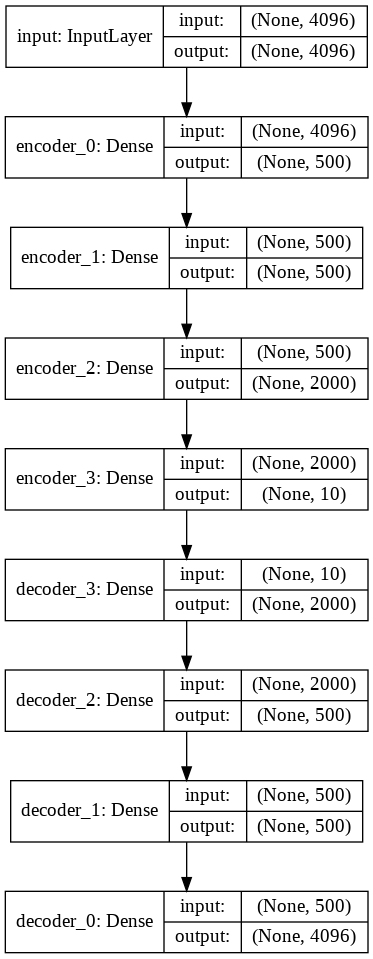

In [14]:
from keras.utils import plot_model
plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)
from IPython.display import Image
Image(filename='autoencoder.png')

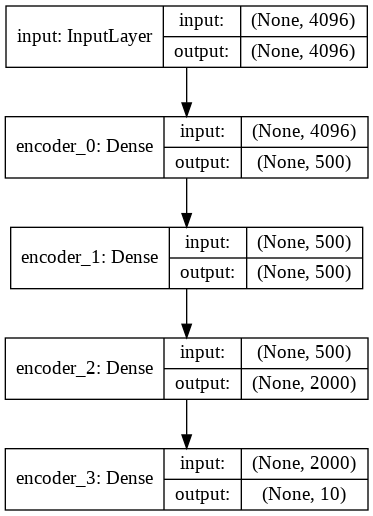

In [15]:
from keras.utils import plot_model
plot_model(encoder, to_file='encoder.png', show_shapes=True)
from IPython.display import Image
Image(filename='encoder.png')

In [16]:
autoencoder.compile(optimizer=pretrain_optimizer, loss='mse')
autoencoder.fit(x, x, batch_size=batch_size, epochs=pretrain_epochs)
#autoencoder.save_weights(save_dir + '/ae_weights.h5')

Epoch 1/15
1274/1274 [==============================] - 2s 1ms/step - loss: 0.0030
Epoch 2/15
1274/1274 [==============================] - 1s 1ms/step - loss: 0.0030
Epoch 3/15
1274/1274 [==============================] - 1s 1ms/step - loss: 0.0030
Epoch 4/15
1274/1274 [==============================] - 1s 1ms/step - loss: 0.0030
Epoch 5/15
1274/1274 [==============================] - 1s 1ms/step - loss: 0.0029
Epoch 6/15
1274/1274 [==============================] - 1s 1ms/step - loss: 0.0029
Epoch 7/15
1274/1274 [==============================] - 1s 1ms/step - loss: 0.0029
Epoch 8/15
1274/1274 [==============================] - 1s 1ms/step - loss: 0.0029
Epoch 9/15
1274/1274 [==============================] - 1s 1ms/step - loss: 0.0028
Epoch 10/15
1274/1274 [==============================] - 1s 1ms/step - loss: 0.0028
Epoch 11/15
1274/1274 [==============================] - 1s 1ms/step - loss: 0.0028
Epoch 12/15
1274/1274 [==============================] - 1s 1ms/step - loss: 0.0028
E

In [17]:
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=clustering_layer)

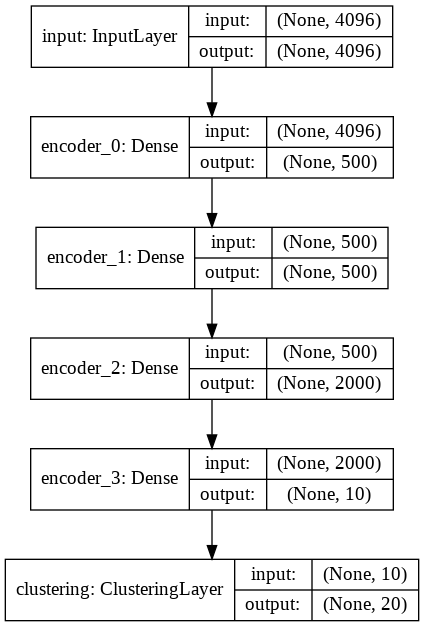

In [18]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
from IPython.display import Image
Image(filename='model.png')

In [19]:
model.compile(optimizer=SGD(0.01, 0.9), loss='kld')

In [20]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))

In [21]:
y_pred_last = np.copy(y_pred)

In [22]:
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

In [23]:
# deep clustering

# computing an auxiliary target distribution
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

    
loss = 0
index = 0
maxiter = 1000 # 8000
update_interval = 100 # 140
index_array = np.arange(x.shape[0])

In [24]:
tol = 0.001 # tolerance threshold to stop training

In [25]:
#Train DEC model iteratively

for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = model.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

#model.save_weights(save_dir + '/DEC_model_final.h5')

In [26]:
# Eval.
q = model.predict(x, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)

In [28]:
#Append Cluster Labels to our preprocessced data frame:

data_all = df.copy()

In [29]:
data_all['cluster'] = y_pred
data_all.head()

,Unnamed: 0,Unnamed: 0.1,_id,topic,heading,content,tags,processed_content,processed_topic,cluster
0,0,0,5f04d2481f35ed6864839349,"[""West-bengal""]","[""\n "",""\n ...","[""Garbage-lined streets and overflowing drains...","[""Garbage"",""Salt-lake"",""Bidhannagar-municipal-...",garbag line street overflow drain salt lake sp...,west bengal,6
1,1,1,5f04d24b1f35ed686483934a,"[""West-bengal""]","[""\n "",""\n ...","[""The Bengal government will set up a plasma b...","[""Calcutta-medical-college-and-hospital"",""Coro...",bengal govern plasma bank calcutta medic colle...,west bengal,17
2,2,2,5f04d24d1f35ed686483934b,"[""West-bengal""]","[""\n "",""\n ...","[""Bengal set another 24-hour record on Monday ...","[""Lockdown"",""Coronavirus"",""Quarantine""]",bengal hour record monday highest number covid...,west bengal,7
3,3,3,5f04d2501f35ed686483934c,"[""West-bengal""]","[""\n "",""\n ...","[""Chief minister Mamata Banerjee on Monday sai...","[""Mamata-banerjee"",""Cyclone-amphan""]",chief minist mamata banerje monday say problem...,west bengal,2
4,4,4,5f04d2531f35ed686483934d,"[""West-bengal""]","[""\n "",""\n ...","[""Some senior historians have raised questions...","[""Jagat-prakash-nadda"",""Bharatiya-janata-party...",senior historian rais question attempt pitch b...,west bengal,11


In [32]:
data_all.to_csv('/content/drive/My Drive/clustered_all_news.csv')

In [30]:
data_all['cluster'].value_counts()

7     278
10    164
2     153
0     101
17     89
13     87
6      83
15     65
5      51
19     47
9      41
14     33
8      29
12     16
11     14
3       8
18      6
16      4
1       4
4       1
Name: cluster, dtype: int64

In [31]:
#Dimension reduction and visualisation of clustering labels

import numpy as np
from sklearn.manifold import TSNE

x_embedded = TSNE(n_components=2).fit_transform(x)

x_embedded.shape

(1274, 2)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


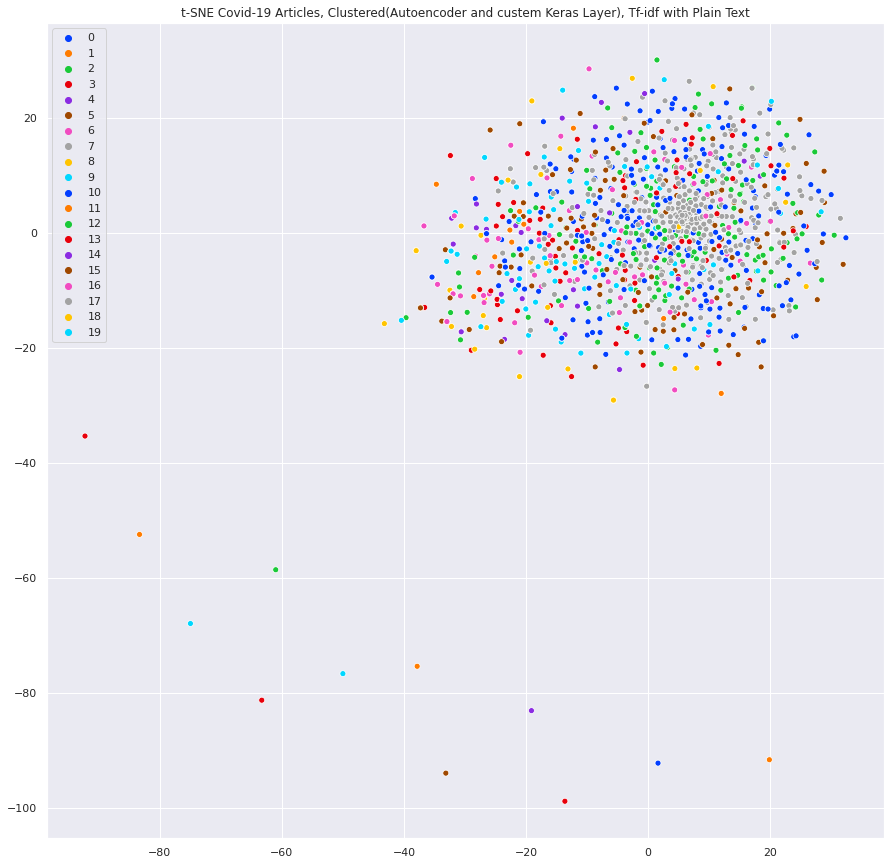

In [33]:
#Plot the Cluster as scatter plot

from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", len(set(y_pred)))

# plot
sns.scatterplot(x_embedded[:,0], x_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title("t-SNE Covid-19 Articles, Clustered(Autoencoder and custem Keras Layer), Tf-idf with Plain Text")
# plt.savefig("plots/t-sne_covid19_label_TFID.png")
plt.show()